1. Install Dependencies

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip list

In [ ]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [11]:
!pip install mss PyAutoGUI pytesseract

2452.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 860.5 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installi

In [147]:
# screen capture
from mss import mss

# send commands
# import pydirectinput
import pyautogui

# opencv allows us to do frame processing
import cv2

# transformaitonal framework
import numpy as np

# OCR for game over extraction
import pytesseract

# visualize captured frames
from matplotlib import pyplot as plt

# for pause
import time

# ENV components
# from gym import Env
# from gym.spaces import Box, Discrete
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

2. Build the environment

In [161]:
class WebGame(Env):
    # sstup the env action and observation shapes
    def __init__(self):
        super().__init__()

        self.observation_space = Box(
            low=0,
            high=255,
            shape=(1, 83, 100),
            dtype=np.uint8,
        )
        # actions: 0 / 1 / 2
        self.action_space = Discrete(3)
        # define extraction params for the game
        self.cap = mss()
        self.game_location = {
            "top": 300,
            "left": 0,
            "width": 600,
            "height": 500,
        }
        self.done_location = {
            "top": 405,
            "left": 330,
            "width": 660,
            "height": 70,
        }

    # what's called to do something in the game
    def step(self, action):
        # action key:
        # key - 0 = space
        # key - 1 = duck
        # key - 2 = no action
        action_map = {
            0: "space",
            1: "down",
            2: "no_op",
        }
        if action != 2:
            # pydirectinput.press(action_map[action])
            pyautogui.press(action_map[action])

        # checking game whether is done
        done, done_cap = self.get_done()
        # get the next observation
        new_observation = self.get_observation()
        # reward - we get a point for every frame we're alive
        reward = 1
        # info dict
        info = {}

        return new_observation, reward, done, info

    # visualize the game
    def render(self):
        cv2.imshow("Game", np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord("q"):
            self.close()

    # restart the game
    def reset(self, seed=0):
        super().reset(seed=seed)

        # click the screen anywhere
        time.sleep(1)

        pyautogui.click(
            x=150,
            y=150,
            clicks=1,
            button="left",
        )
        pyautogui.press("space")

        # info dict
        info = {}

        return self.get_observation(), info

    # close down the observation
    def close(self):
        cv2.destroyAllWindows()

    # get the part of the observation of game that we want
    def get_observation(self):
        # get screen capture of game
        screenshot = self.cap.grab(self.game_location)
        raw = np.array(screenshot)[:, :, :3]  # get rid of alpha
        raw.astype(np.uint8)

        # grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)

        # resize
        resized = cv2.resize(gray, (100, 83))

        # add channel
        channel = np.reshape(resized, (1, 83, 100))

        return channel

    # get the done text
    def get_done(self):
        # get done screen
        done_cap = self.cap.grab(self.done_location)
        raw = np.array(done_cap)[:, :, :3]

        # validate done text
        done_strings = [
            "GAME",
            "GAHE",
        ]
        done = False
        res = pytesseract.image_to_string(raw)[:4]
        if res in done_strings:
            done = True

        return done, raw

In [162]:
env = WebGame()

In [33]:
# env.action_space.sample()

In [97]:
# plt.imshow(env.observation_space.sample()[0])

# plt.imshow(env.get_observation())

# plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

# done, done_cap = env.get_done()
# done
# plt.imshow(done_cap)

# env.render()

# env.close()

env.reset()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

3. Test env

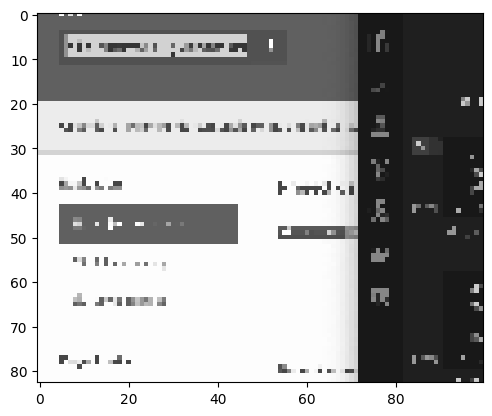

In [153]:
env = WebGame()
obs = env.get_observation()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [106]:
done, done_cap = env.get_done()
done

pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [107]:
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward

    print(f"Total reward for episode {episode} is {total_reward}")

Total reward for episode 0 is 22
Total reward for episode 1 is 27
Total reward for episode 2 is 23
Total reward for episode 3 is 26
Total reward for episode 4 is 27
Total reward for episode 5 is 31
Total reward for episode 6 is 26
Total reward for episode 7 is 34
Total reward for episode 8 is 52
Total reward for episode 9 is 24


3. Create callback

In [159]:
# !pip install git+https://github.com/DLR-RM/stable-baselines3

# !pip install gymnasium

# !pip install setuptools==65.5.0
# !pip install stable-baselines3==1.8.0
# !pip install stable-baselines3[extra]
# !pip install Shimmy

import os
# save models
from stable_baselines3.common.callbacks import BaseCallback
# check env
from stable_baselines3.common import env_checker

In [ ]:
env_checker.check_env(env)

In [124]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(
                self.save_path, "best_model_{}".format(self.n_calls)
            )
            self.model.save(model_path)

        return True

In [164]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

3.2 build DQN and train

In [ ]:
from stable_baselines3 import DQN

model = DQN(
    "CnnPolicy",
    env,
    tensorboard_log=LOG_DIR,
    verbose=1,
    buffer_size=1200000,
    learning_starts=1000,
)

model.learn(total_timesteps=5000, callback=callback)

4. Test out model

In [ ]:
model = DQN.load(os.path.join("train_first", "best_model_88000"))

for episode in range(1):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward += reward

    print(f"Total reward for episode {episode} is {total_reward}")
